# Spatial Integration of MSI and MSI


In this notebook we show that MIIT can also be used to integrate different types of MSI data. In this example, we load two randomly sampled datasets, one presents msi data retrieved in 
positive ion mode (imzml_pos) and the other msi data retrieved in negative ion mode (imzml_neg). Then, we register and transform imzml_neg into the image of imzml_pos and export the result data as an imzML file.

In the previous tutorial, we combined all data into `Section` objects that allow to contain multiple data in the same image space. However, when only
working with one type of data, we can also use that data type directly instead of embedding into a `Section`. 

Note, that this function is still experimental at this point.

In [1]:
import os
from os.path import exists

import SimpleITK as sitk
import matplotlib.pyplot as plt

from miit.spatial_data.section import Section, register_to_ref_image
from miit.spatial_data.base_types import Image
from miit.spatial_data.spatial_omics.imzml import Imzml, export_imzml
from miit.registerers import GreedyFHistExt
from miit.registerers.other.msi_to_hist_meta_registerer import MSItoHistMetaRegisterer

In [2]:
if not exists('output_directory'):
    os.mkdir('output_directory')

### Load Data

In [3]:
# First we load our target data: Imzml containing msi data retrieved in positive ion mode.
registerer = MSItoHistMetaRegisterer()

msi_pos_image_path = '../data/hist/section2/reference_image.tif'
imzml_pos_path = '../data/msi_pos/data.imzML'

msi_pos_image = Image.load_from_path(msi_pos_image_path)
imzml_pos = Imzml.init_msi_data(imzml_pos_path, name='positive ion mode')
imzml_pos, _ = register_to_ref_image(msi_pos_image.data, imzml_pos.get_pca_img().data, imzml_pos, registerer)

# Next, we load the data source data: Imzml containing msi data retrieved in negative ion mode.

msi_neg_hist_image_path = '../data/hist/section3/reference_image.tif'
imzml_neg_path = '../data/msi_neg/data.imzML'

msi_neg_image = Image.load_from_path(msi_neg_hist_image_path)
imzml_neg = Imzml.init_msi_data(imzml_neg_path, name='negative ion mode')
imzml_neg, _ = register_to_ref_image(msi_neg_image.data, imzml_neg.get_pca_img().data, imzml_neg, registerer)
# neg_section = Section(reference_image=msi_neg_hist_image, so_data=[imzml_neg])

/home/maximilw/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(
/home/maximilw/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(
/home/maximilw/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(


Text(0.5, 1.0, 'Histology MSI positive ion mode.')

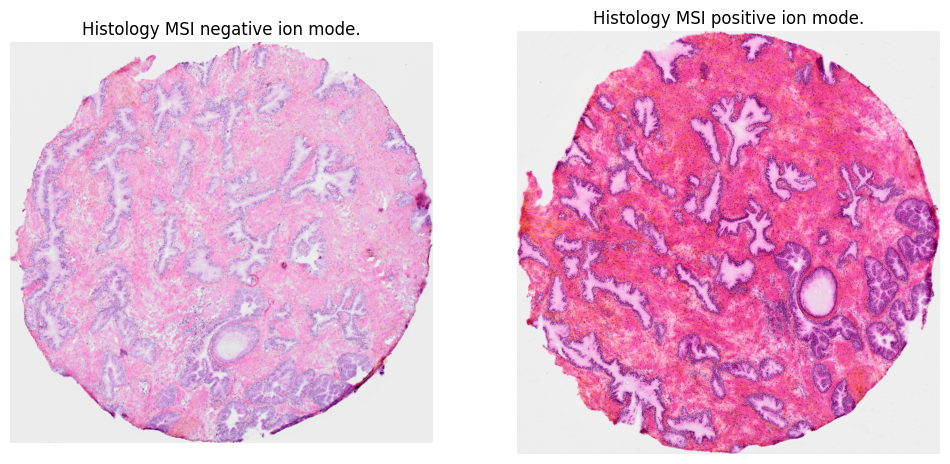

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(msi_pos_image.data)
axs[0].set_title('Histology MSI negative ion mode.')
axs[1].imshow(msi_neg_image.data)
axs[1].set_title('Histology MSI positive ion mode.')


### Registration

In [5]:
registerer = GreedyFHistExt.init_registerer(path_to_greedy='greedy')

transformation = registerer.register_images(
    moving_img=msi_neg_image.data,
    fixed_img=msi_pos_image.data
)

warped_msi_neg_image = msi_neg_image.apply_transform(registerer, transformation)
warped_imzml = imzml_neg.apply_transform(registerer, transformation)

/home/maximilw/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(


Text(0.5, 1.0, 'Registered negative ion mode msi section')

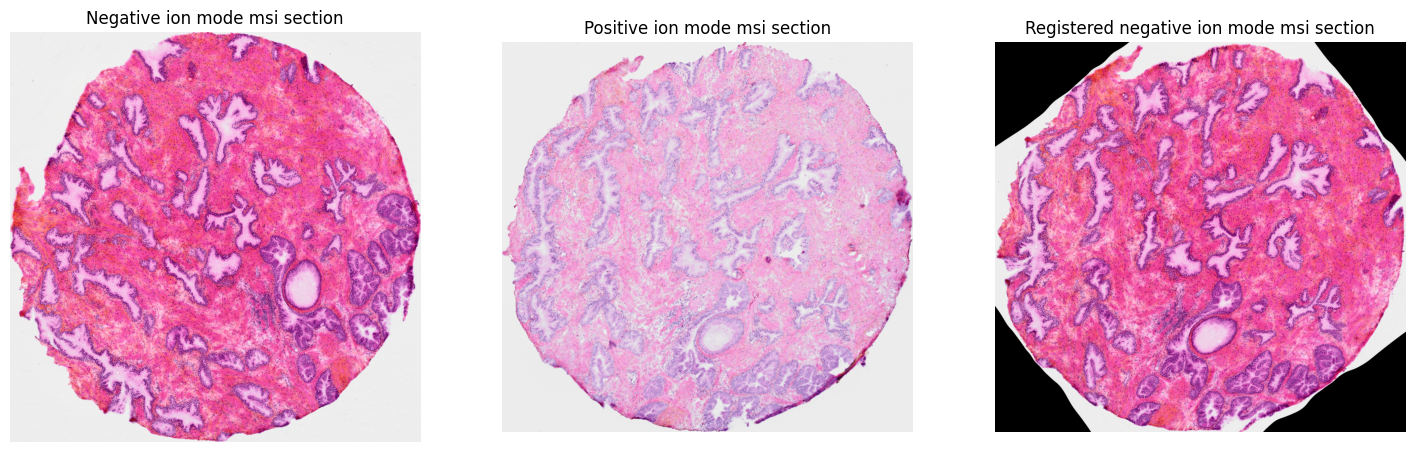

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(msi_neg_image.data)
axs[0].set_title('Negative ion mode msi section')
axs[1].imshow(msi_pos_image.data)
axs[1].set_title('Positive ion mode msi section')
axs[2].imshow(warped_msi_neg_image.data)
axs[2].set_title('Registered negative ion mode msi section')

###  Transformation from negative to positive ion mode msi

In [7]:
from miit.spatial_data.spatial_omics.imzml import (
    get_metabolite_intensities_targeted, 
    msi_default_accumulate_spot_weighted_mean, 
)
from miit.integration.integration import (
    get_mappings, 
    map_mapping_index_to_table_index, 
    accumulate_counts
)
from pyimzml.ImzMLParser import ImzMLParser

In [8]:
msi_pos_data = imzml_pos
msi_neg_data = warped_imzml
mappings, spots_background, unique_target_reference = get_mappings(msi_pos_data.ref_mat.data, msi_neg_data.ref_mat.data, msi_pos_data.background, msi_neg_data.background)

In [9]:
msi_pixel_idxs = msi_neg_data.set_map_to_msi_pixel_idxs(unique_target_reference)
msi_mappings = msi_neg_data.mappings_map_to_msi_pixel_idxs(mappings)
msi = ImzMLParser(msi_neg_data.config['imzml'])
msi_pos = ImzMLParser(msi_pos_data.config['imzml'])
metabolites_df = get_metabolite_intensities_targeted(msi, msi_pixel_idxs)
metabolites_df.head()

0          1          2          3           4           5     \
123.774  13.171091  31.194967  77.615845  97.788445  104.587982  100.027939   
131.899   0.088008   0.797741   0.613922   0.253439    0.019411    0.040094   
139.512   0.011477   0.154711   0.066605   0.085851    0.054557    0.202255   
144.889   0.030401   0.009336   0.056474   0.003128    0.034930    0.000462   
145.623   0.105758   0.042593   0.039928   0.017247    0.024568    0.033717   

             6          7          8          9     ...       7342       7343  \
123.774  7.365383  45.406445  90.710495  89.617325  ...  58.729740  28.710361   
131.899  1.178375   0.524792   0.004177   0.196929  ...   2.833724   1.519847   
139.512  0.220208   0.291796   0.031473   0.384949  ...   3.555549   0.210979   
144.889  0.005783   0.010794   0.083908   0.149881  ...   0.613088   0.512152   
145.623  0.069701   0.005077   0.030189   0.012234  ...   0.147011   0.337697   

             7344       7345       7346        7347        7348       7349  \
123.774  0.496102  83.271500  41.196804  124.757797  100.801765  36.237965   
131.899  0.911508   1.846237   0.668339    0.066503    0.734536   1.011046   
139.512  0.687597   1.564395   0.325905    0.425435    0.440795   0.492106   
144.889  0.081209   0.000641   0.081285    0.097135    0.176101   0.110951   
145.623  0.445186   0.014116   0.025640    0.036806    0.095675   0.165381   

              7350       7351  
123.774  83.897652  91.423393  
131.899   0.097008   0.487089  
139.512   0.794276   1.135255  
144.889   0.473920   0.161080  
145.623   0.074414   0.038301  

[5 rows x 7325 columns]

In [10]:
accumulated_df = accumulate_counts(msi_mappings, metabolites_df, spots_background, msi_default_accumulate_spot_weighted_mean)
integrated_df = map_mapping_index_to_table_index(accumulated_df, msi_neg_data)
integrated_df.head()

123.774   131.899   139.512   144.889   145.623   166.713   173.750  \
3983  14.494901  0.117259  0.189552  0.067624  0.065201  0.634357  0.147748   
3980  35.495946  0.492049  0.364641  0.079048  0.044624  1.087855  0.311543   
3981  22.651072  0.442607  0.758573  0.073152  0.052509  0.242609  0.174523   
3982  52.362653  0.180508  0.264464  0.091697  0.061639  0.429515  0.071024   
3984  34.211983  0.112420  0.109163  0.186901  0.059373  0.360192  0.061997   

       174.563   174.642    190.782  ...   812.018   816.280   833.289  \
3983  0.215538  0.139493   9.413005  ...  0.116382  0.157398  0.376104   
3980  1.477541  0.070385  16.414962  ...  0.108137  0.060598  0.165454   
3981  2.118737  0.060142  28.543973  ...  0.121299  0.014933  0.106373   
3982  2.048621  0.102691  25.157597  ...  0.072650  0.040419  0.131987   
3984  1.239292  0.025019  60.709387  ...  0.071236  0.030409  0.071195   

       834.014   835.307   838.090   844.132   857.444   861.433   863.246  
3983  0.835287  0.038632  1.510623  0.023738  0.027864  0.916435  0.918349  
3980  0.322881  0.056097  1.343555  0.075794  0.072652  0.519032  0.846326  
3981  0.427700  0.031909  2.354539  0.097449  0.102027  0.356964  0.986499  
3982  0.674008  0.088410  2.519303  0.072236  0.082236  0.240104  2.545906  
3984  0.544386  0.118448  1.123359  0.092039  0.061128  0.088240  3.339267  

[5 rows x 40 columns]

Similarly to the previous tutorial, we can map the integrated data onto the reference matrix format to get an image presentation. (Note the noise in the image data due to the random sampling.)

In [11]:
ion_images = msi_pos_data.to_ion_images(integrated_df.transpose())
labels = integrated_df.columns.to_list()

In [12]:
ion_images.labels = labels

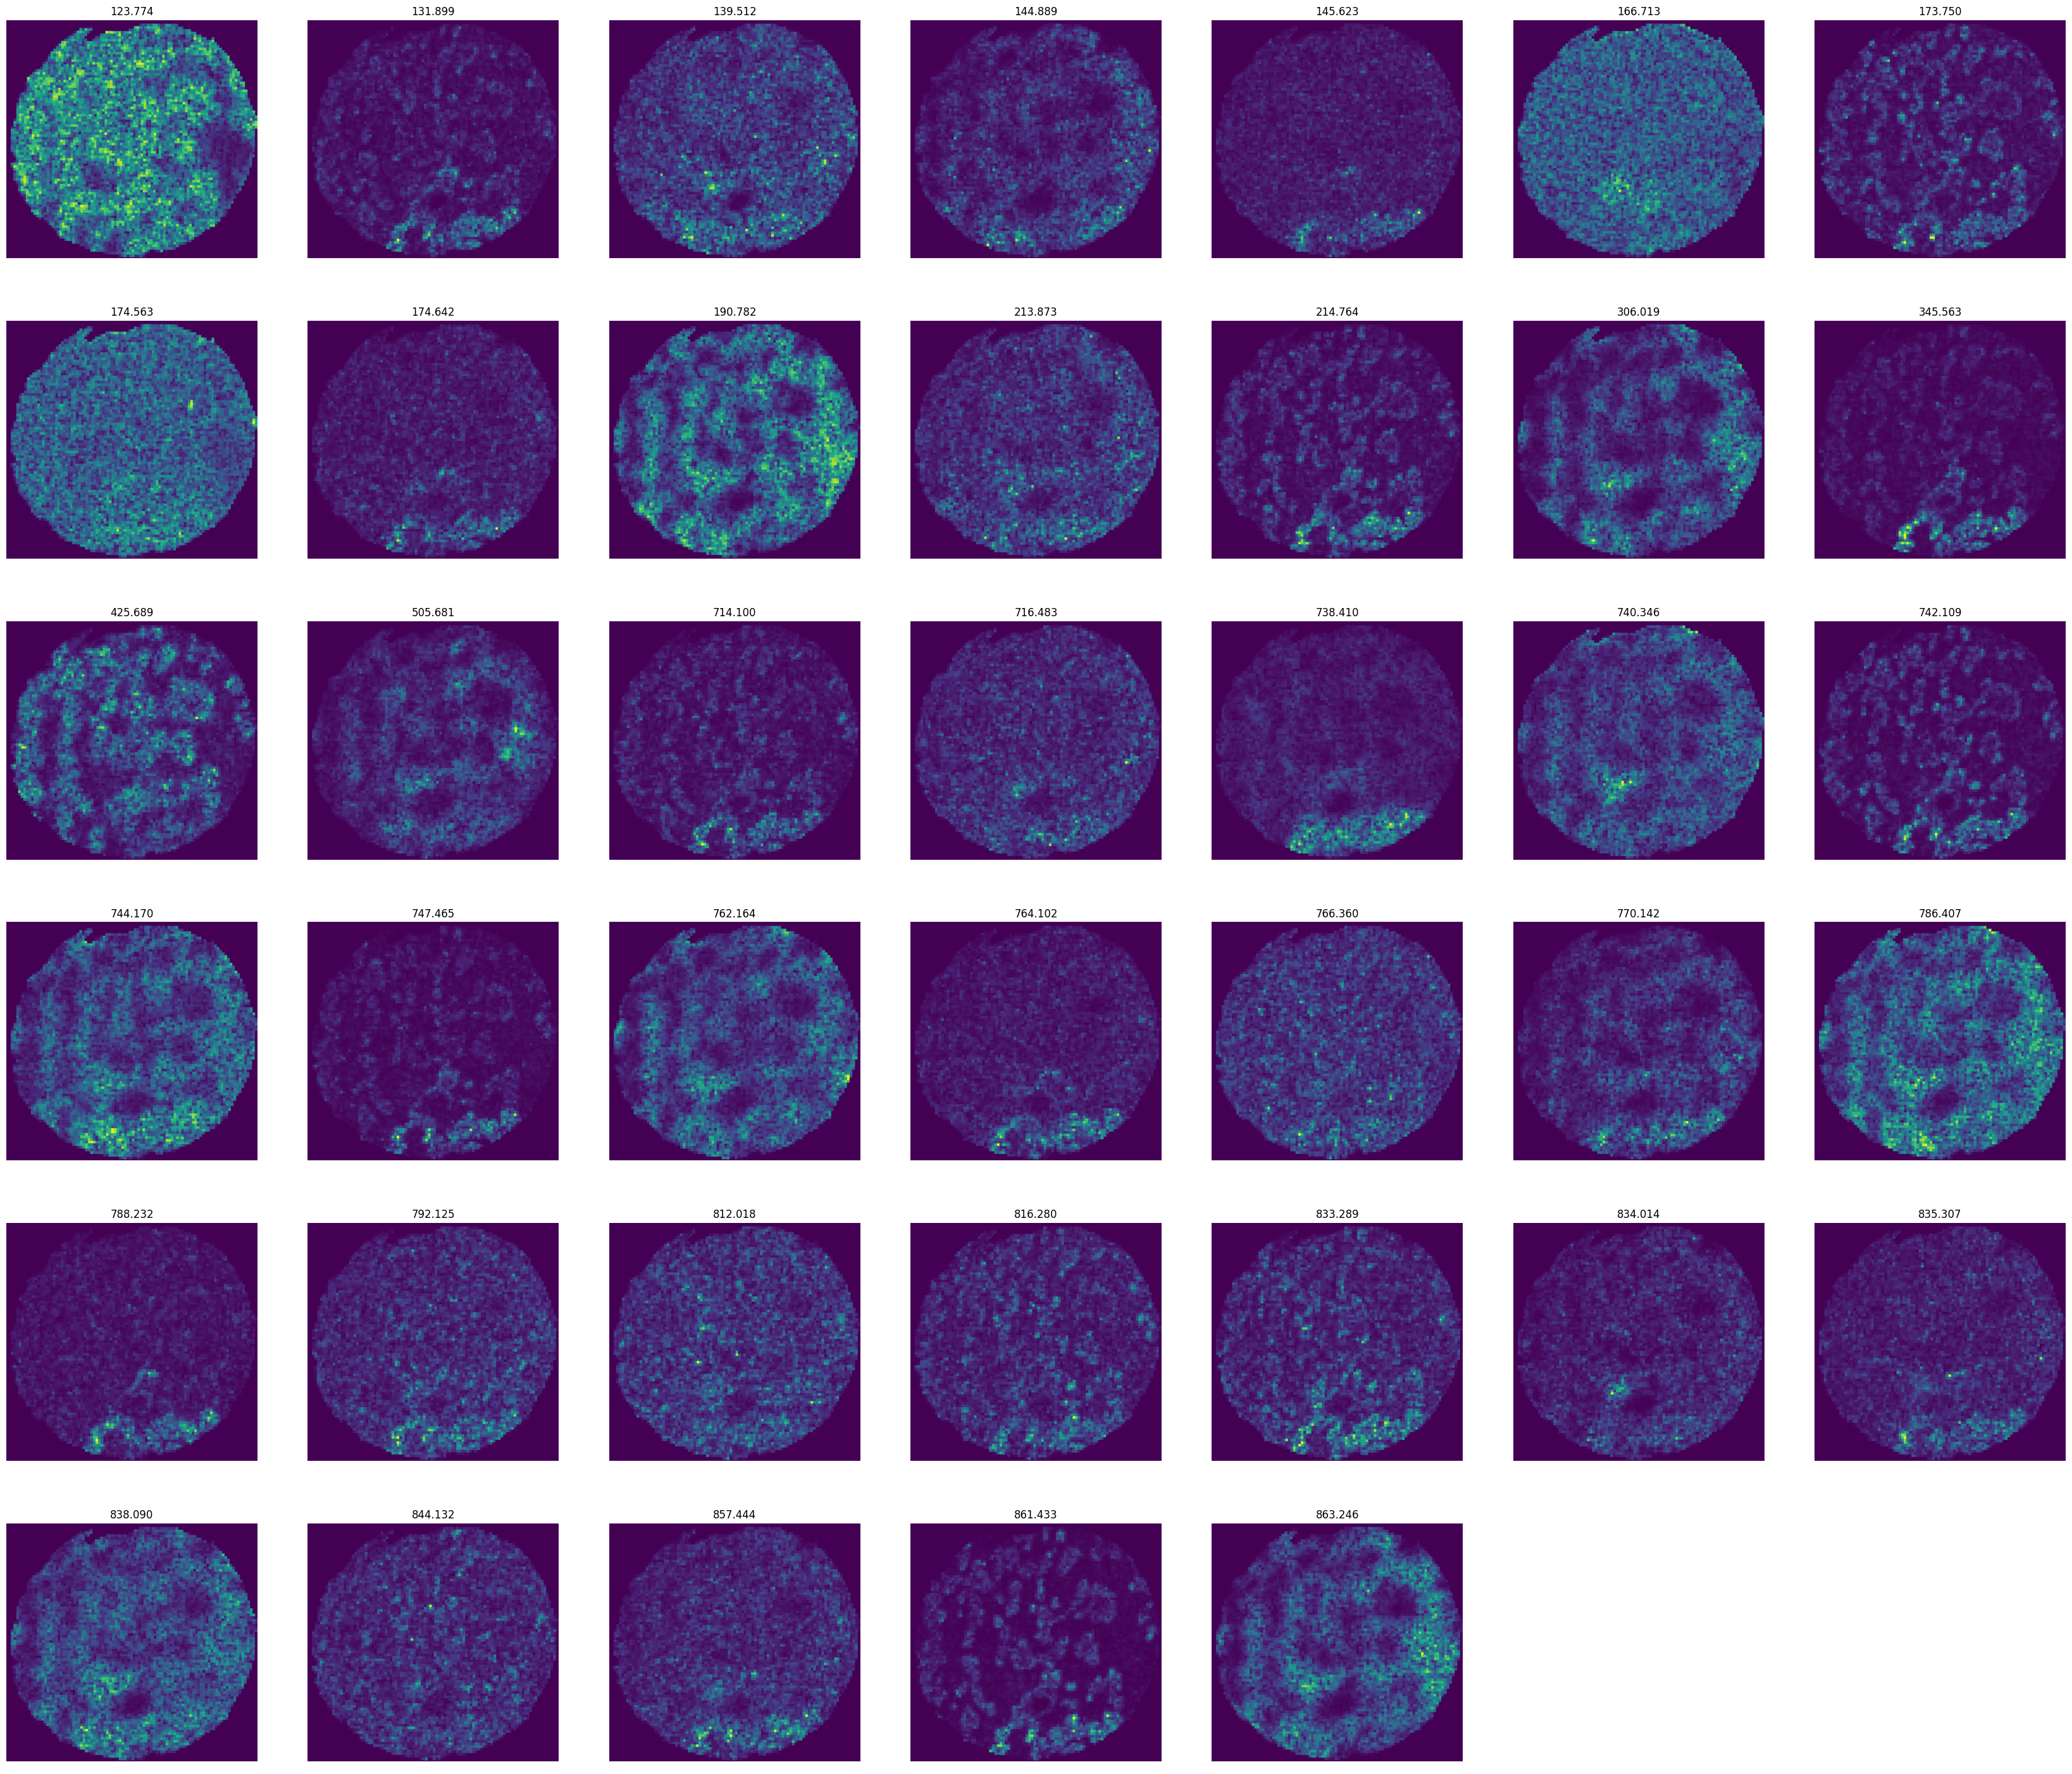

In [13]:
ion_images.plot_annotation()

### Export

For msi data, we can export data in the imzML format.

In [14]:
# Note that this function is still very experimental!
export_imzml(msi_pos, 'output_directory/integrated_msi_neg.imzML', integrated_df)